# ResBlock in Tensorflow (Functional API)

This notebook shows how a ResBlock from ResNetV2 is implemented in the functional API. Your task is to implement the same or a similar architecture using the sub-classing API instead, in order to build a ResNet.

In Residual connections, we skip one or more layers (in this case Conv2D layers) and add the input of the block to the output of the block. Note that you have to make sure that the dimensions match, which is why we set padding to "same". If the number of feature maps (channels) changes, you need to perform a 1x1 convolution to the number of feature maps in the input of the layer.

In ResNetV2, there are three different kinds of ResBlocks. They are implemented below by choosing the mode argument in res_block. When mode is set to "strided", strided convolutions are used and strided 1x1 "pooling" is used to shrink the feature map size. With mode set to "normal", we do not change the size of the feature maps but can control the number of channels that we get in the output. With mode set to "constant", we keep both the size and the number of channels constant.

Recall the differences between the Functional API and the Sub-Classing API:

- In the functional API, you don't need an init in which we list all the layers that we will use

- In the subclassing API you need to define all the layers (and on a lower level the variables) that you use in the call method. Do not have excess layers in the init that you do not use in the call method.

- In the functional API, you can simply ignore the batch dimension in the operations that we do. Tensorflow/Keras take care of the batch dimension.

- In the subclassing API, you need to think about the batch dimension when writing the layers (especially important for concatenating two tensors within a layer). You should not see dimensions of None anywhere when using sub-classing!


In [1]:
import tensorflow as tf

In [2]:
def res_block(x, n_filters=64, out_filters=256, mode="normal"):

    """
    Instantiates the layers and computations involved in a residual block from ResNet V2.
    
    Args:
    x (KerasTensor) : Input to the block
    
    n_filters (int) : changes the number of filters used by the first convolutions
    
    out_filters (int) : changes the number of channels of the output
    
    mode (str) : either "normal", "strided" or "constant". See the markdown text above.
    """
    
    # use batch normalization and a non-linearity (relu)
    x_out = tf.keras.layers.BatchNormalization()(x) 
    x_out = tf.keras.layers.Activation(tf.nn.relu)(x_out)
    
    x_out = tf.keras.layers.Conv2D(filters=n_filters, kernel_size =(1,1))(x_out)
    
    x_out = tf.keras.layers.BatchNormalization()(x_out) 
    x_out = tf.keras.layers.Activation(tf.nn.relu)(x_out)
    
    # There are three kinds of blocks
    if mode == "normal":
        
        x_out = tf.keras.layers.Conv2D(filters=n_filters, kernel_size =(3,3), padding="same")(x_out)
        
        # transform original input to also have 256 channels
        x = tf.keras.layers.Conv2D(filters=out_filters, kernel_size=(1,1))(x) 
    
    # some blocks in ResNetV2 have a MaxPool with 1x1 pool size and strides of 2 instead
    elif mode == "strided":
        
        # set number of output channels to match number of input channels (else we need a 1x1 convolution)
        out_filters = x.shape[-1]
        
        # do strided convolution (reducing feature map size)
        x_out = tf.keras.layers.Conv2D(filters=n_filters, kernel_size =(3,3), padding="same", 
                                       strides=(2,2))(x_out)
        
        # transform original input with 1x1 strided max pooling to match output shape
        x = tf.keras.layers.MaxPool2D(pool_size=(1,1), strides=(2,2))(x)
        
    # other ResNetV2 blocks keep both the size and channel number constant
    elif mode == "constant":
        
        x_out = tf.keras.layers.Conv2D(filters=n_filters, kernel_size =(3,3), padding="same")(x_out)
        
    x_out = tf.keras.layers.BatchNormalization()(x_out)
    x_out = tf.keras.layers.Activation(tf.nn.relu)(x_out)
    
    x_out = tf.keras.layers.Conv2D(filters=out_filters, kernel_size =(1,1))(x_out)

    # Add x and x_out
    x_out = tf.keras.layers.Add()([x_out, x])
    
    return x_out

In [4]:
# Instantiate model with the three types of res-blocks

# Define pseudo-input (this type of thing does not exist with sub-classing!)
x_in = tf.keras.layers.Input(shape= (32,32,3))

# have an initial Conv layer before the first res block (increasing the n of channels)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")(x_in)

# changes n of channels
x_out = res_block(x, n_filters=64, out_filters=256, mode="normal")

# shrinks feature maps, changes n of channels 
x_out = res_block(x_out, n_filters=128, out_filters=256, mode="strided")

# keeps feature map size and n of channels
x_out = res_block(x_out, n_filters= 256, out_filters=256, mode="constant")

model = tf.keras.Model(x_in, x_out)

In [5]:
# in the subclassing API, you need to call the model on an input before model.summary() works
model.summary() 

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 32, 32, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 32, 32, 32)   128         conv2d_11[0][0]                  
__________________________________________________________________________________________________
activation_9 (Activation)       (None, 32, 32, 32)   0           batch_normalization_9[0][0]      
____________________________________________________________________________________________

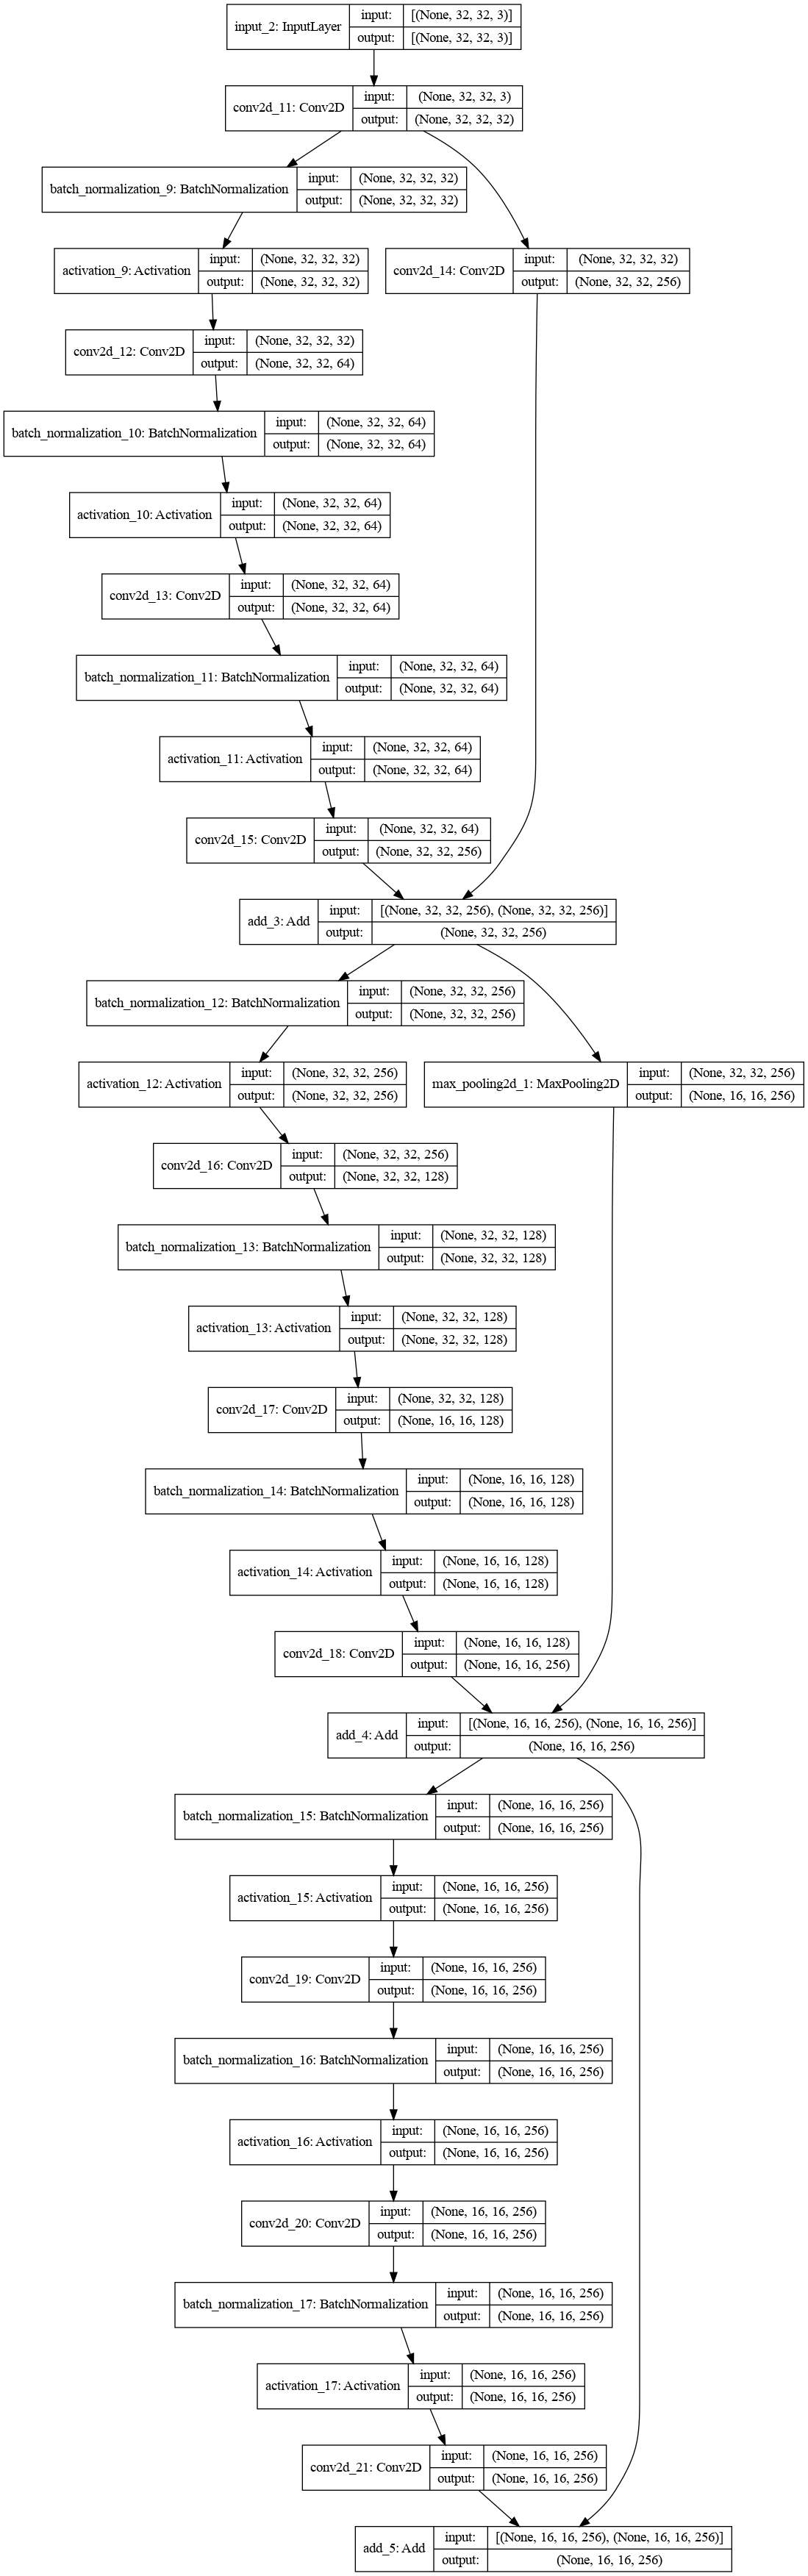

In [6]:
# plotting a model graph only works for functional API models
tf.keras.utils.plot_model(model, show_shapes=True) 

# Task for homework: 

- Implement a ResBlock similar to the above by subclassing tf.keras.layers.Layer and use it to build a model that is subclassed from tf.keras.Model with a custom train loop